# Lab6.3-Topic-modelling

This notebook shows how to build a topic model using Latent Dirichlet Allocation using the Sklearn package.

Credits: This notebook is an adaptation of the work of Shashank Kapadia:

https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/

The dataset can be found here: https://www.kaggle.com/benhamner/nips-papers


In [3]:
# Importing modules
import pandas as pd
import os

os.chdir('/Users/axelehrnrooth/Desktop/Text Mining/other/lab6data/')

# Read data into papers
papers = pd.read_csv('./NIPSpapers/papers.csv')

# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


#### Data Cleaning

Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

In [4]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


#### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text. Note that we care less about the linguistic notion of words and sentences since we treat the text as a basic bag-of-words.

In [5]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/var/folders/12/wd9t8m850v12fpd_v81hh2hm0000gn/T/ipykernel_96851/734592226.py:5: SyntaxWarning: invalid escape sequence '\.'
  papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))


0    767\n\nself-organization of associative databa...
1    683\n\na mean field theory of layer iv of visu...
2    394\n\nstoring covariance by the associative\n...
3    bayesian query construction for neural\nnetwor...
4    neural network ensembles cross\nvalidation and...
Name: paper_text_processed, dtype: object

#### Exploratory Analysis

To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

You can install WordCloud from the command line following the instructions at:

https://anaconda.org/conda-forge/wordcloud


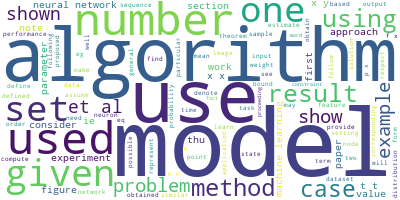

In [7]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

#### Prepare text for LDA analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary. For this we use the CountVectorizer package from sklearn and apply the *fit_transform* function to the lists of texts from our pandas frame.

We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud. This is done by the Helper function defined below using the matplotlib.

In [10]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['paper_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

### LDA model tranining

To keep things simple, we will only tweak the number of topic parameters: number_topics and number_words.

We apply the *fit* function to our count_data.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


In [6]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
model data models distribution algorithm matrix log 10 using inference

Topic #1:
training learning image model data using images set features network

Topic #2:
data function learning kernel algorithm problem 10 set xi matrix

Topic #3:
model network time neural input figure learning neurons networks function

Topic #4:
algorithm learning function set state policy time problem value optimal


In [7]:
test_data=["my images are difficult to learn", "it takes a lot of time to train a model"]
transformed_test_data= count_vectorizer.transform(test_data)
print(transformed_test_data)

  (0, 120549)	1
  (0, 163063)	1
  (0, 183684)	1
  (1, 189182)	1
  (1, 201629)	1
  (1, 268021)	1
  (1, 272347)	1
  (1, 274903)	1


In [8]:
lda.transform(transformed_test_data)

array([[0.05042464, 0.79835033, 0.05028909, 0.0504089 , 0.05052705],
       [0.03414945, 0.58565228, 0.03374475, 0.31227469, 0.03417884]])

### Analyzing our LDA model

Now that we have a trained model let’s visualize the topics for interpretability. 
To do so, we’ll use a popular visualization package, *pyLDAvis* which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.
For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

You need to install *pyldavis* through the command line, following the instructions:

https://anaconda.org/conda-forge/pyldavis

WARNING: running the next cell takes a long time and you need some memory to run it. However, the result is spectacular.

In [10]:
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
pyLDAvis.enable_notebook()
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
LDAvis_prepared

/Users/iliamarkov/Documents/work/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.042559 -0.012332       1        1  23.270451
2      0.091403 -0.011234       2        1  22.298041
1     -0.077715 -0.104160       3        1  20.561075
3     -0.136116  0.077526       4        1  17.406310
4      0.079869  0.050199       5        1  16.464124, topic_info=       Category           Freq          Term          Total  loglift  logprob
162992  Default   29415.000000         image   29415.000000  30.0000  30.0000
207886  Default   43705.000000       network   43705.000000  29.0000  29.0000
176183  Default   25064.000000        kernel   25064.000000  28.0000  28.0000
227697  Default   15188.000000        policy   15188.000000  27.0000  27.0000
80706   Default   80827.000000     algorithm   80827.000000  26.0000  26.0000
274943  Default   46477.000000      training   46477.000000  25.0000  25.0000
163063  Default   18965.000000        images   18965.000000  24.0000  24.0000
201629  Default  102133.000000         model  102133.000000  23.0000  23.0000
208290  Default   13274.000000       neurons   13274.000000  22.0000  22.0000
208040  Default   43890.000000        neural   43890.000000  21.0000  21.0000
213579  Default   13386.000000        object   13386.000000  20.0000  20.0000
194320  Default   42604.000000        matrix   42604.000000  19.0000  19.0000
165698  Default   33801.000000         input   33801.000000  18.0000  18.0000
261733  Default   33886.000000         state   33886.000000  17.0000  17.0000
240396  Default    9375.000000        regret    9375.000000  16.0000  16.0000
270986  Default   25208.000000       theorem   25208.000000  15.0000  15.0000
110561  Default   18305.000000        convex   18305.000000  14.0000  14.0000
183058  Default   16681.000000         layer   16681.000000  13.0000  13.0000
239371  Default   13995.000000   recognition   13995.000000  12.0000  12.0000
272347  Default   58987.000000          time   58987.000000  11.0000  11.0000
207921  Default   31585.000000      networks   31585.000000  10.0000  10.0000
164807  Default   19469.000000     inference   19469.000000   9.0000   9.0000
208266  Default    9149.000000        neuron    9149.000000   8.0000   8.0000
96419   Default   25036.000000         bound   25036.000000   7.0000   7.0000
242980  Default    9043.000000        reward    9043.000000   6.0000   6.0000
201740  Default   47687.000000        models   47687.000000   5.0000   5.0000
183744  Default  104079.000000      learning  104079.000000   4.0000   4.0000
77336   Default   11869.000000        action   11869.000000   3.0000   3.0000
188366  Default   39610.000000           log   39610.000000   2.0000   2.0000
260189  Default    8026.000000         spike    8026.000000   1.0000   1.0000
...         ...            ...           ...            ...      ...      ...
236022   Topic5    2485.684648       queries    3013.789389   1.6113  -7.0772
117050   Topic5    6996.273518      decision   10753.198401   1.3742  -6.0424
85725    Topic5    2881.983248           arm    3610.529526   1.5786  -6.9293
216471   Topic5    6014.969350        online    9493.317571   1.3476  -6.1935
261733   Topic5   15891.065382         state   33886.502583   1.0467  -5.2220
80706    Topic5   29398.056812     algorithm   80827.027579   0.7926  -4.6069
96419    Topic5   11702.331570         bound   25036.305993   1.0434  -5.5280
217278   Topic5   12119.328018       optimal   27039.331759   1.0015  -5.4930
282955   Topic5   12330.523955         value   28086.776246   0.9808  -5.4757
183744   Topic5   28447.302565      learning  104079.252785   0.5069  -4.6397
96481    Topic5    6874.015398        bounds   13376.909314   1.1382  -6.0600
80762    Topic5   11973.704927    algorithms   33409.546236   0.7779  -5.5051
111493   Topic5    6974.118162          cost   14436.569476   1.0764  -6.0456
143189   Topic5   18500.994429      function   68818.272310   0.4903 

## BERT topic modeling

Read the Maarten Grootendorst's work on topic modeling with BERT:

https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

https://towardsdatascience.com/interactive-topic-modeling-with-bertopic-1ea55e7d73d8

## End of this notebook